In [24]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tabulate import tabulate

ModuleNotFoundError: No module named 'tabulate'

In [14]:
with sqlite3.connect("../laliga.sqlite") as con:
    df=pd.read_sql_query("SELECT * FROM Matches",con)
    dr=pd.read_sql_query("SELECT * FROM Predictions",con)

In [17]:
dr.head()

,season,division,matchday,date,time,home_team,away_team,score,pred


C:\Users\sofia\AppData\Local\Temp\ipykernel_30696\1280398712.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["score_home_team"] = df["score"].str.split(":").str[0].astype(float)
C:\Users\sofia\AppData\Local\Temp\ipykernel_30696\1280398712.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["score_away_team"] = df["score"].str.split(":").str[1].astype(float)


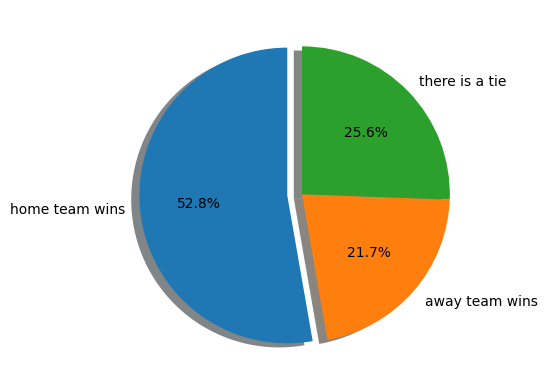

In [29]:
# Exercise 1

df = df.dropna(subset=['score'])

df["score_home_team"] = df["score"].str.split(":").str[0].astype(float)
df["score_away_team"] = df["score"].str.split(":").str[1].astype(float)

home_wins = (df['score_home_team'] > df['score_away_team']).sum()
away_wins = (df['score_home_team'] < df['score_away_team']).sum()
ties = (df['score_home_team'] == df['score_away_team']).sum()

sizes = [home_wins, away_wins, ties]
labels = ['home team wins', 'away team wins', 'there is a tie']
explode = (0.1, 0, 0)

fig, ax = plt.subplots()
ax.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
       shadow={'ox': -0.04, 'edgecolor': 'none', 'shade': 0.9}, startangle=90)
plt.show()

In [23]:
# Exercise 2

df_first_division = df[df['division'] != 2]

goals_scored = df_first_division.groupby('home_team')['score_home_team'].sum() + df_first_division.groupby('away_team')['score_away_team'].sum()
top_scorers = goals_scored.sort_values(ascending=False).head(10)

goals_conceded = df_first_division.groupby('home_team')['score_away_team'].sum() + df_first_division.groupby('away_team')['score_home_team'].sum()
top_conceders = goals_conceded.sort_values(ascending=False).head(10)

top_scorers.plot(x='nombre', y='valor', kind='bar',color='c')
plt.xlabel('teams')
plt.ylabel('goals')
plt.title('most scoring teams')
plt.show()

top_conceders.plot(x='nombre', y='valor', kind='bar',color='r')
plt.xlabel('teams')
plt.ylabel('goals')
plt.title('most conceding teams')
plt.show()

df_first_division['score_difference'] = np.abs(df_first_division["score_home_team"] - df_first_division["score_away_team"])
df_first_division['game_name'] = df_first_division["home_team"] + ' vs ' + df_first_division["away_team"]
differences= df_first_division.iloc[:,-2:].sort_values(by='score_difference',ascending=False).head(10)

table = tabulate(differences, headers='keys', tablefmt='pretty', showindex=False)
print(table)


#df_first_division["score_difference"] = np.abs(df_first_division["score_home_team"] - df_first_division["score_away_team"])


KeyError: 'Column not found: score_home_team'

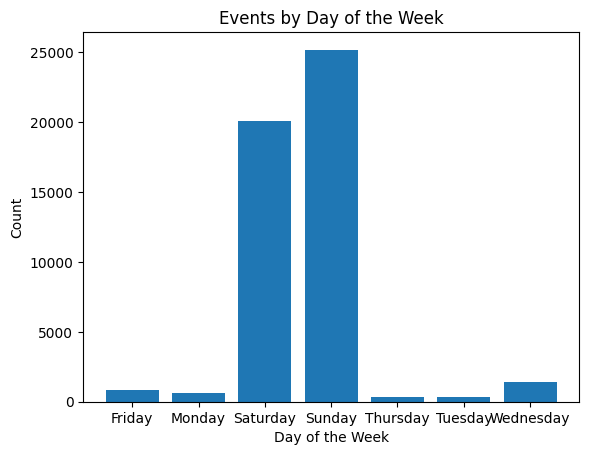

In [22]:
# Exercise 3

df['date'] = pd.to_datetime(df['date'], format='%m/%d/%y')
df['Day_of_Week'] = df['date'].dt.day_name()

day_of_week_counts = df['Day_of_Week'].value_counts().sort_index()

plt.bar(day_of_week_counts.index, day_of_week_counts)
plt.xlabel('Day of the Week')
plt.ylabel('Count')
plt.title('Events by Day of the Week')
plt.show(
    
)

In [28]:
# Exercise 6

'''Between 1979 and 1980, Real Sociedad managed to chain a total of 38 games
without losing. That was, by far, the longest undefeated streak in their his-
tory. Which teams have had the longest undefeated streaks? Show the
longest undefeated streaks in a horizontal bar plot, indicating in each bar
the team name and the dates it held that streak, for instance, Real Sociedad
22/04/1979 - 04/05/1980.'''


df.head()

#n_undefeated = df['Day_of_Week'].value_counts().sort_index()
'''
1) choose a team
2) away or home?
3) retrieve score and compare
4) if winner, keep
5) sort by date
6) check continuous date

'''
df.head()


,season,division,matchday,date,time,home_team,away_team,score,winner,Day_of_Week
0,1928-1929,1,1,2029-02-10,None,Arenas Club,Athletic Madrid,2:3,None,Saturday
1,1928-1929,1,1,2029-02-10,None,Espanyol,Real Unión,3:2,None,Saturday
2,1928-1929,1,1,2029-02-10,None,Real Madrid,Catalunya,5:0,None,Saturday
3,1928-1929,1,1,2029-02-10,None,Donostia,Athletic,1:1,None,Saturday
4,1928-1929,1,1,2029-02-12,None,Racing,Barcelona,0:2,None,Monday


In [58]:
df['winner'] = df.apply(lambda row: row['home_team'] if row['score_home_team'] > row['score_away_team'] else row['away_team'], axis=1)

df['match_won'] = df['winner'] == df['home_team']
df['streak'] = (df['match_won'] != df['match_won'].shift()).cumsum()

max_streak_length = df.groupby('streak').size().max()
print(f"The all-time maximum winning streak is: {max_streak_length}")


The all-time maximum winning streak is: 18
